In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import re 
import nltk
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

File descriptions

train.csv - the training set

test.csv - the test set

Data fields

ItemID - id of twit

Sentiment - sentiment

SentimentText - text of the twit


0 - negative

1 - positive

### Reading Train and Test data

In [2]:
X= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
X.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


### Checking if there any null values present in data sets for both train and test 

In [5]:
X.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [6]:
test.isnull().sum()

id       0
tweet    0
dtype: int64

### Counts of Class

[]

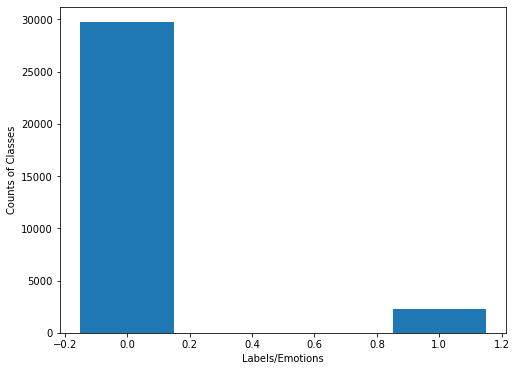

In [7]:
em=dict(X['label'].value_counts())
key= list(em.keys())
val= list(em.values())
plt.figure(figsize=(8,6))
plt.bar(key,val,width=0.3)
plt.xlabel('Labels/Emotions')
plt.ylabel('Counts of Classes')
plt.plot()

### Plotting Histogram for string length in Tweet

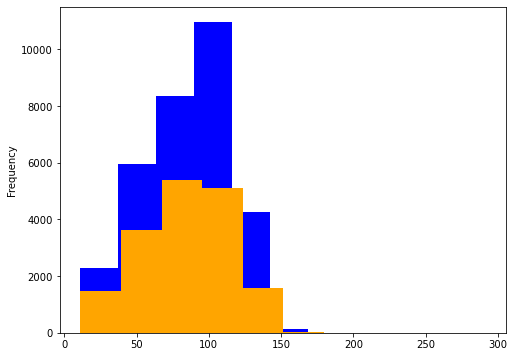

In [8]:
train_len = X['tweet'].str.len().plot.hist(color = 'blue', figsize = (8,6))
test_len = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (8,6))

### Plotting Histogram for Negative and Postive String length in Tweet

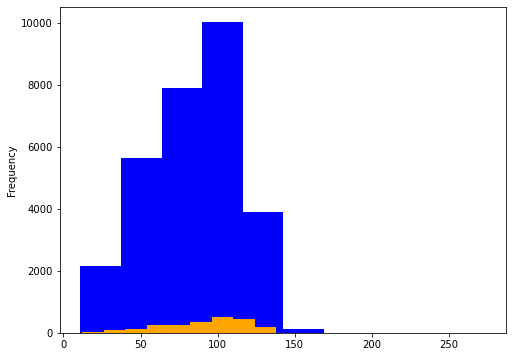

In [9]:
neg_train= X[X['label']==0]
pos_train= X[X['label']==1]

neg_len = neg_train['tweet'].str.len().plot.hist(color = 'blue', figsize = (8,6))
pos_len = pos_train['tweet'].str.len().plot.hist(color = 'orange', figsize = (8,6))

### As we can observe that Positive tweets are mostly shorter than negative tweets, we are adding length of the string as feature(columns) in a dataset.

In [10]:
#Adding String length as feature in dataset
X['len'] = X['tweet'].str.len()
test['len'] = test['tweet'].str.len()

### Counting most frequent Words occuring

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 20')

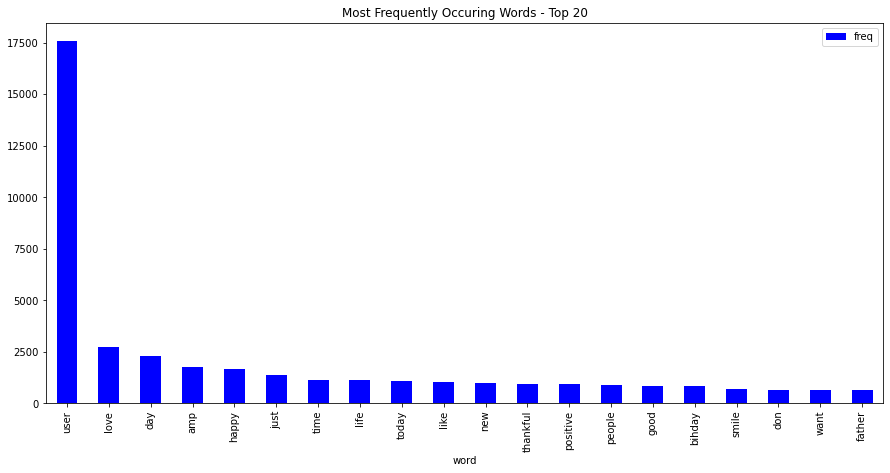

In [11]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(X.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 20")

### Cleaning Text by removing special symbol, punctuation, fixing word, lemmatizing and etc..

In [12]:
lm= WordNetLemmatizer()
def data_cleaning(data):
    #for i in range(len(data)):
    text=[]
    wrt= re.sub(r'@\S+','',data) 
    hyp= re.sub(r"-", " ", wrt)
    sym= re.sub(r"\([^()$]*\)", "", hyp)
    phrase=re.sub(r"won't","will not",sym)
    phrase=re.sub(r"can't","can not",phrase)
    phrase=re.sub(r"couldn't","could not",phrase)
    phrase=re.sub(r"coz","because",phrase)
    phrase=re.sub(r"hasn't","has not",phrase)
    phrase=re.sub(r"don't","do not",phrase)
    phrase=re.sub(r"didn't","did not",phrase)
    phrase=re.sub(r"isn't"," is not",phrase)
    phrase=re.sub(r"'re"," are",phrase)
    phrase=re.sub(r"'d"," would",phrase)
    phrase=re.sub(r"'ll"," will",phrase)
    phrase=re.sub(r"'ve"," have",phrase)
    phrase=re.sub(r"'m"," am",phrase)
    phrase=re.sub(r"'s"," is",phrase)
    phrase= re.sub('[^A-Za-z]+', ' ',phrase)
    word= phrase.split()
    #print(word)
    for i in word:
        if len(i)>2:
            text.append(lm.lemmatize(i))
    #print(text)
    return text

In [13]:
#Data cleaning for train dataset
tweet_train= X['tweet']
text_train=[]
for i in range(len(tweet_train)):
    dc= data_cleaning(tweet_train[i])
    text_train.append(dc)

In [14]:
#Data Cleaning for test dataset
tweet_test= test['tweet']
text_test=[]
for i in range(len(tweet_test)):
    dc= data_cleaning(tweet_test[i])
    text_test.append(dc)

In [15]:
#Removing commas from text for each datapoint
def pre_process(data):
    text_list=[]
    for i in data:
        ll=','.join(map(str,i))
        h=ll.replace(',',' ')
        text_list.append(h)
    return text_list

pre_train= pre_process(text_train)
pre_test= pre_process(text_test)

#### Adding Preprocess Tweet to a dataset

In [16]:
X['preprocess_tweet']= pre_train
test['preprocess_tweet']= pre_test

In [17]:
#Creating Dataframe for Train and Test Split
y= X['label']
X_df= X.drop(['id','label','tweet'],axis=1)
X_df

,len,preprocess_tweet
0,102,when father dysfunctional and selfish drag his...
1,122,thanks for lyft credit can not use cause they ...
2,21,bihday your majesty
3,86,model love take with all the time
4,39,factsguide society now motivation
...,...,...
31957,68,ate isz that youuu
31958,131,see nina turner the airwave trying wrap hersel...
31959,63,listening sad song monday morning otw work sad
31960,67,sikh temple vandalised calgary wso condemns act


In [18]:
#Splitting data into Train and Test with 80:20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.20,stratify=y)

### Data Preprocessing by Tf-Idf and Normalizing

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.sparse
# Applying Tf-IDF in datapoints
tf_idf= TfidfVectorizer(max_features=10000)
train_tweet= X_train['preprocess_tweet']
test_tweet= X_test['preprocess_tweet']
tf_idf.fit(train_tweet.values)
x_train_tf= tf_idf.transform(train_tweet.values)
x_test_tf= tf_idf.transform(test_tweet.values)

norm= Normalizer()
len_tr= X_train['len'].values
len_te= X_test['len'].values
tr= norm.fit(len_tr.reshape(-1,1))
x_tr_len = tr.transform(len_tr.reshape(-1,1))
x_te_len = tr.transform(len_te.reshape(-1,1))
print(x_tr_len.shape)
print(x_te_len.shape)

(25569, 1)
(6393, 1)


In [20]:
X_tr = hstack((x_train_tf,x_tr_len)).tocsr()
X_te = hstack((x_test_tf,x_te_len)).tocsr()

### Multinomial-Naive Bayes model

#### Hyperparameter Tuning

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# Finding the best Hyper-parameter
parameter = {'alpha':[0.01,0.1,0.2,0.4,0.5,1]}
nb = MultinomialNB(class_prior=[0.5,0.5])
clf = GridSearchCV(nb, parameter, cv=3,scoring='f1',return_train_score=True)
clf.fit(X_tr,y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [0.01, 0.1, 0.2, 0.4, 0.5, 1]},
             return_train_score=True, scoring='f1')

In [22]:
print(clf.best_estimator_)
best_p= clf.best_params_
print('Best Hyper-parameter:',clf.best_params_)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5])
Best Hyper-parameter: {'alpha': 1}


In [23]:
nb_best= MultinomialNB(class_prior=[0.5,0.5],alpha= 1)

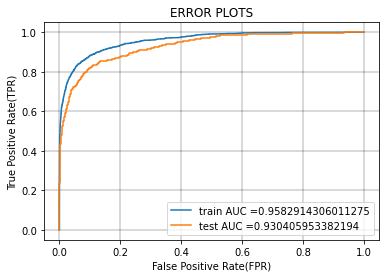

In [24]:
nb_best.fit(X_tr, y_train)
model= joblib.dump(nb_best,'nb_model.pkl')
y_score1 = nb_best.predict_proba(X_tr)[:,1]
y_score2 = nb_best.predict_proba(X_te)[:,1]
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_score1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_score2)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.show()

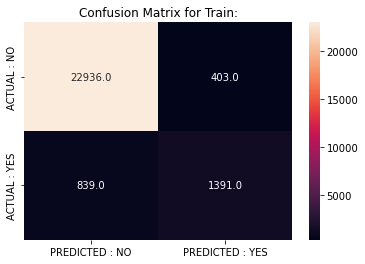

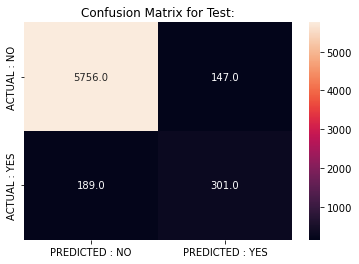

In [25]:
y_train_pred = nb_best.predict(X_tr)
y_test_pred = nb_best.predict(X_te)
cmtr= confusion_matrix(y_train_pred, y_train)
sns.heatmap(cmtr,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Train:')
plt.show()
cmte= confusion_matrix(y_test_pred, y_test)
sns.heatmap(cmte,annot= True,fmt='0.1f',xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'])
plt.title('Confusion Matrix for Test:')
plt.show()

In [26]:
f1_train= f1_score(y_train,y_train_pred)
f1_test= f1_score(y_test,y_test_pred)

### Calculating F1-Score

In [27]:
print("Train F1-Score: ",f1_train)
print("Test F1-Score: ",f1_test)

Train F1-Score:  0.6913518886679919
Test F1-Score:  0.6417910447761194


In [28]:
model= joblib.load('nb_model.pkl')

In [29]:
tf_idf= TfidfVectorizer(max_features=10000)
test_tweet= test['preprocess_tweet']
tf_idf.fit(test_tweet.values)
x_test_tf= tf_idf.transform(test_tweet.values)
print(x_test_tf.shape)

norm= Normalizer()
len_te= test['len'].values
tr= norm.fit(len_te.reshape(-1,1))
x_test_len = tr.transform(len_te.reshape(-1,1))
print(x_test_len.shape)

Test_Set = hstack((x_test_tf,x_test_len)).tocsr()

(17197, 10000)
(17197, 1)


In [30]:
test_predict= model.predict(Test_Set)

In [31]:
test_predict

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)